In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsort_keygen # for sorting string indicies
from quetzal.io import excel

# Post-processing

## Saves energy demand of passenger transport

## Needs total pkm within Germany

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Load results in pkm
results = {}
for scen in ['base', '2035_base']:
    results[scen] = pd.read_csv(output_path + scen + '/' + 'pkm.csv', index_col=0)

In [14]:
# Aggregate traffic by mode
pkm = pd.DataFrame()
for scen, res in results.items():
    pkm[scen] = res.groupby('mode').agg({'pkm': 'sum'})

In [15]:
# Extrapolate 2035 values to 2050
increase = 1 + (0.07)*(1 + 15/18)
pkm['2050'] = pkm['base'] * increase # linear extrapolation
pkm / 1e9

,base,2035_base,2050
mode,,,
air,1.548605,1.749428,1.747343
bus,59.205586,66.432149,66.803636
car,1077.858661,1184.546767,1216.183856
coach,12.178307,9.290413,13.741190
rail_long,13.453389,28.438550,15.179908
rail_short,75.568969,56.437836,85.266987
walk,28.627982,60.424275,32.301907


In [16]:
# Total traffic
pkm.sum() / 1e9

base         1268.441499
2035_base    1407.319418
2050         1431.224825
dtype: float64

In [17]:
# Difference 2017 to 2050
pkm['2050'].sum() / pkm['base'].sum() -1

0.12833333333333363

## Add international air traffic

Data from eurostat ("Air passenger transport by reporting country"; online data code: AVIA_PAOC).

Aggregated figures from the German Federal Transport Ministry for 2017: 67.5 bio. (thereof 10.4 bio. domestic)

In [18]:
pkm.drop('air', inplace=True, errors='ignore')
# Assume same increase of air traffic as for the rest of traffic
pkm.loc['air_domestic'] = [10.4*1e9 for _ in pkm.columns]
pkm.loc['air_domestic', '2050'] = pkm.loc['air_domestic', 'base'] * increase
pkm.loc['air_international'] = [57.1*1e9 for _ in pkm.columns]
pkm.loc['air_international', '2050'] = pkm.loc['air_international', 'base'] * increase

<AxesSubplot:ylabel='base'>

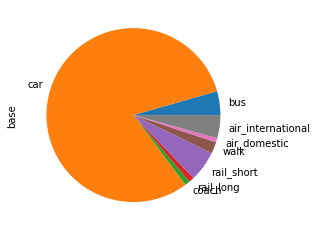

In [19]:
pkm['base'].plot.pie()

## Energy intensity

Energy intensities depend on the transport technology and its propulsion system. There  are the following data sets available:
* TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* better overview of TREMOD data for today here: https://www.umweltbundesamt.de/daten/verkehr/endenergieverbrauch-energieeffizienz-des-verkehrs#spezifischer-energieverbrauch-sinkt
* Easy diagrams for today here: https://www.allianz-pro-schiene.de/presse/pressemitteilungen/ferienstart-im-umweltvergleich-liegt-die-bahn-vorn/
* Projections for 2050 (choosing figures for fully electrified drivetrains): Robinius, M. et al. (2020). Kosteneffiziente und Klimagerechte Transformationsstrategien für das deutsche Energiesystem bis zum Jahr 2050. Jülich.
* Maximum efficiency assumptions for 2050: Millward-Hopkins, J., Steinberger, J. K., Rao, N. D., & Oswald, Y. (2020). Providing decent living with minimum energy: A global scenario. Global Environmental Change, 65, 102168. https://doi.org/10.1016/j.gloenvcha.2020.102168

None of the sources provides a comprehensive picture. The final energy demand ist of interest (without conversion losses in the energy supply chain).

In [21]:
# energy demands in kWh/pkm
pkm.sort_index(inplace=True, key=natsort_keygen()) # sort alphabetical
intensity = pd.DataFrame(index=pkm.index,
                         data={'base': [2.76/3.6,
                                        2.5/3.6,
                                        0.9/3.6,
                                        2.14/3.6,
                                        0.41/3.6,
                                        0.51/3.6,
                                        0.86/3.6,
                                        0],
                               '2050': [2.76/3.6, # from today
                                        2.5/3.6, # from today
                                        1/10.626, # Battery-electric bus
                                        1/7.143 / params['car_occ']['all'], # BEV
                                        1/10.626, # Battery-electric bus
                                        1/23.419, # Electric train
                                        1/23.419, # Electric train
                                        0],
                               '2050_eff': [0.98/3.6,
                                            0.98/3.6,
                                            0.18/3.6,
                                            0.35/3.6,
                                            0.18/3.6,
                                            0.06/3.6,
                                            0.06/3.6,
                                            0]
                              })

## Energy demand

Calculate the final energy demand

In [72]:
# For 2050 global sufficiency, take pkm data from Millward-Hopkins et al. 2020
pop = 80103978
pkm_sufficiency = pd.Series({'air_domestic': 0,
                             'air_international': 1067*pop,
                             'bus': 2714/2*pop,
                             'car': 679*pop,
                             'coach': 0,
                             'rail_long': 2714/2*pop,
                             'rail_short': 0,
                             'walk': 1251*pop})
demand = pd.DataFrame(index=intensity.index,
                      data={'2017': pkm['base'] * intensity['base'],
                            '2017 global sufficiency': intensity['base'] * pkm_sufficiency,
                            '2050': pkm['2050'] * intensity['2050'],
                            '2050 max. efficiency': pkm['2050'] * intensity['2050_eff'],
                            '2050 global sufficiency': intensity['2050_eff'] * pkm_sufficiency})
demand / 1e9

,2017,2017 global sufficiency,2050,2050 max. efficiency,2050 global sufficiency
mode,,,,,
air_domestic,7.973333,0.000000,8.996578,3.194437,0.000000
air_international,39.652778,59.354823,44.741551,17.538688,23.267090
bus,14.801396,27.175275,6.286809,3.340182,5.435055
car,640.727093,32.332191,113.508223,118.240097,5.287975
coach,1.386974,0.000000,1.293167,0.687059,0.000000
rail_long,1.905897,15.399322,0.648188,0.252998,1.811685
rail_short,18.052587,0.000000,3.640932,1.421116,0.000000
walk,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
# Aggregate modes
demand['transport mode'] = ['air', 'air', 'road PT', 'MIT', 'road PT', 'rail', 'rail', 'active']
demand['Transportmodus'] = ['Flugzeug', 'Flugzeug', 'ÖSPV', 'MIV', 'ÖSPV', 'Schiene', 'Schiene', 'aktiv']
demand_agg = demand.groupby('Transportmodus').sum() / 1e9 * 3.6

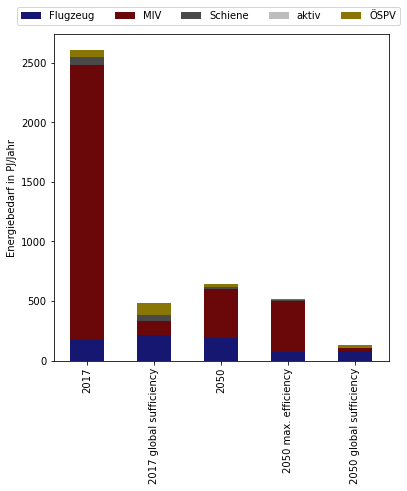

In [74]:
# Plot
fig, ax = plt.subplots(figsize=(6,6))
demand_agg.T.plot.bar(stacked=True, ax=ax, legend=False,
                      #ylabel='energy demand in PJ/year',
                      #color=['#690709', '#bdbdbd', '#151770', '#887706', '#494949'])
                      ylabel='Energiebedarf in PJ/Jahr',
                      color=['#151770', '#690709', '#494949','#bdbdbd', '#887706'])
ax.legend(ncol=len(demand), bbox_to_anchor=(1.05,1.1))
#for pos in ['right', 'top']:
#    plt.gca().spines[pos].set_visible(False)

In [69]:
demand['2050 global sufficiency'].sum() / demand['2050 max. efficiency'].sum()

0.24746438424441783

In [71]:
# Sufficiency with today's technology --> energy demand in PJ
(pkm_sufficiency * intensity['base']).sum() / 1e9 *3.6

483.3417959735401